In [9]:
import csv
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

from constants import *
from PIL import Image
from enum import Enum

# Embeds graphs in Jupyter notebook (instead of pop-ups)
%matplotlib inline

pd.set_option('display.max_columns', None) # show all columns
pd.set_option('display.max_rows', None) # show all rows

In [10]:
teams_agg_df = pd.read_csv('./data/teams/teams_agg.csv')

In [11]:
def get_correlation(df, columns):
    '''Returns correlation between selected columns'''
    df_corr = df[columns].corr().abs() # get correlation matrix; absolute values for strength of correlation
    df_corr = df_corr.where(np.triu(np.ones(df_corr.shape)).astype(bool)) # get upper triangular values only
    df_corr = df_corr.stack().sort_values(ascending=False).reset_index()
    df_corr.columns = ['col_1', 'col_2', 'corr']
    return df_corr[df_corr['corr'] < 1].reset_index(drop=True)

def get_indiv_correlation(df, col_1, col_2, print_corr=True):
    corr_df = df.select_dtypes(include=[np.number]).corr()[col_1].reset_index()
    corr = corr_df[corr_df['index'] == col_2][col_1].iloc[0]
    if print_corr:
        print(
            f"{'No strong' if abs(corr) < 0.7 else 'Strong'} correlation between {col_1}",
            f"and {col_2} (corr = {corr:.2f})"
        )
    return corr

def in_different_category(col1, col2):
    for col in TEAM_COLUMNS_DICT_COMBINED.values():
        if col1 in col and col2 in col:
            return False
    return True

def get_outliers(df, col, show_info=True, sort_ascending=False):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers_df = df[
        (df[col] < Q1-1.5*IQR) |
        (df[col] > Q3+1.5*IQR)
    ].sort_values(by=col, ascending=sort_ascending).reset_index(drop=True)
    if show_info:
        if len(outliers_df) > 0:
            print("\nOutliers:")
            display(outliers_df)
        print("\nOverview:")
        display(df.describe())
    return outliers_df

def get_upper_deviation(df, col):
    return round(df[df[col] >= df[col].quantile(0.99)][col].mean(), 2)

def get_lower_deviation(df, col):
    return round(df[df[col] <= df[col].quantile(0.01)][col].mean(), 2)

def plot_regression_line(df, x_col, y_col):
    x_data = df[x_col].to_numpy()
    y_data = df[y_col].to_numpy()
    m, b = np.polyfit(x_data, y_data, 1)
    plt.plot(x_data, m*x_data+b, color='red')

In [12]:
# For getting icons when plotting graphs
class IconType(Enum):
    CLUB = "club_icons"
    COUNTRY = "country_icons"

#     "Cache" icons once processed
ICON_CACHE = { IconType.CLUB.name: {}, IconType.COUNTRY.name: {}, }
CLUB_ICON_MAPPING = dict(zip(SQUAD_NAME_MAPPING["final"], SQUAD_NAME_MAPPING["transfermarkt"]))
CLUB_ICON_MAPPING.update({"Empoli": "FC Empoli"})

def get_icon(type_: IconType, icon_name: str, scale: float = 0.1) -> Image:
    icon = ICON_CACHE[type_.name].get(icon_name)
    if icon:
        return icon
#     Find image
    img = Image.open(f"./data/{type_.value}/{icon_name}.png")
#     Resize
    ICON_CACHE[type_.name][f"{icon_name}_{scale}"] = img.resize((int(img.width*scale), int(img.height*scale)), Image.Resampling.LANCZOS)
    return ICON_CACHE[type_.name][f"{icon_name}_{scale}"]

def get_country_icon(country_name: str, scale: float = 0.02) -> Image:
    return get_icon(type_=IconType.COUNTRY, icon_name=country_name, scale=scale)

def get_club_icon(squad_name: str, scale: float = 0.1) -> Image:
#     Note: need to map name in dataframe to saved name (as images taken from transfermarkt)
    return get_icon(type_=IconType.CLUB, icon_name=CLUB_ICON_MAPPING[squad_name], scale=scale)

#     Set custom markers for all clubs
def set_club_markers(df, x_col, y_col, squad_col="squad"):
    for _, row in df.iterrows():
        plt.gca().add_artist(AnnotationBbox(
            OffsetImage(get_club_icon(row[squad_col])),
            (row[x_col], row[y_col]),
            frameon=False, pad=0)
        )

In [13]:
class GROUPBY_TYPE(Enum):
    CLUB = "squad"
    COUNTRY = "country"

def plot_grouped_line_graph(type_: GROUPBY_TYPE, col, agg_func=np.mean, transform_col_func=None):
    """Plot a line graph that tracks a change in a variable over the seasons, grouping by country"""
    year_cols = [type_.value, "season_start_year"]
    df = teams_agg_df[[*year_cols, col]].groupby(year_cols).agg(agg_func).reset_index()

#     For xticks and club icon markings
    start_years = list(df["season_start_year"].unique())
    
    if transform_col_func:
        df[col] = transform_col_func(df[col])

    plt.figure(figsize=(8, 6))
    
    if type_ == GROUPBY_TYPE.COUNTRY:
        for group in list(df[type_.value].unique()):
            # Plot line for each country
            filtered_df = df[df[type_.value] == group]
            plt.plot(filtered_df["season_start_year"], filtered_df[col], label=group)

            #     Add icon
            for i in range(len(filtered_df)):
                plt.gca().add_artist(AnnotationBbox(
                    OffsetImage(get_country_icon(group, scale=0.03)),
                    (filtered_df["season_start_year"].iloc[-1], filtered_df[col].iloc[-1]),
                    frameon=False,
                    pad=0
                ))
    elif type_ == GROUPBY_TYPE.CLUB:
        added_icons = []
#         Get number of seasons in dataset for each club
        df_count = df.groupby(type_.value)[type_.value].count()
#         Get total number of seasons in dataset
        num_seasons = len(df["season_start_year"].unique())
#         Get clubs that appear in every season
        df = df[df.apply(
            lambda row: df_count[df_count.index == row[type_.value]].iloc[0] >= num_seasons,
            axis=1
        )].sort_values(by=col).reset_index(drop=True)
        for quantile in np.arange(0, 1.1, 0.25):
            # Plot line for each quantile if not exists
            quantile_value = df[df["season_start_year"] == start_years[-1]][col].quantile(quantile)
            squad_to_add = df.at[(df[col] == quantile_value).idxmax(), type_.value]
            if not squad_to_add in added_icons:
                added_icons.append(squad_to_add)

#                 Filter by club and sort by year before plotting
                filtered_df = df[df[type_.value] == squad_to_add].sort_values(by="season_start_year")
                plt.plot(filtered_df["season_start_year"], filtered_df[col], label=squad_to_add)
                
#                 Add icon
                for i in range(len(filtered_df)):
                    plt.gca().add_artist(AnnotationBbox(
                        OffsetImage(get_club_icon(squad_to_add)),
                        (filtered_df["season_start_year"].iloc[i], filtered_df[col].iloc[i]),
                        frameon=False,
                        pad=0
                    ))                        

    # Set graph labels
    plt.legend(
        title="Legend",
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0
    )
    plt.gca().set_xticks(range(start_years[0], start_years[-1]+1))
    plt.gca().set_xticklabels(labels=[f"{x}-{x+1-2000}" for x in start_years])
    plt.grid(True)
    
def plot_country_line_graph(col, agg_func=np.mean, transform_col_func=None):
    plot_grouped_line_graph(type_=GROUPBY_TYPE.COUNTRY, col=col, agg_func=agg_func, transform_col_func=transform_col_func)

def plot_club_line_graph(col, agg_func=np.mean, transform_col_func=None):
    """Plots line graph for club at each quartile (based on last season's values)"""
    plot_grouped_line_graph(type_=GROUPBY_TYPE.CLUB, col=col, agg_func=agg_func, transform_col_func=transform_col_func)

### Win Determinants

Correlation with points per game (PPG)
<br><br>
<i>
    <b>How PPG works</b>
    <ul>
        <li>Win = 3 pts; draw = 1 pt; lose = 0 pts</li>
        <li>PPG = # points in a season / # games in a season</li>
        <li>In this section, we sum PPG from each season played from 2018-2023, and divide it by the number of seasons</li>
    </ul>
    <b>Why PPG?</b>
    <ol>
        <li>Because data is from domestic leagues which uses the point system to rank teams at the end of the season. Teams are given prize money, qualification into continental competition, etc. based on their league standings, which is why using points is the most meaningful metric of success (as opposed to win rate, for example).</li>
        <li>PPG takes draws into account, making comparison easier.</li>
        <li>Last of all, points are averaged on a per-game basis as different leagues may play a different number of games (teams usually play each other twice, once at home and once away, each league may have a different number of teams).</li>
    </ol>
</i>

In [14]:
# Now select only the numeric columns for correlation
numeric_df = teams_agg_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
corr_matrix['points_per90'].sort_values()

gk_goals_against_per90                  -0.745066
goals_against_per90                     -0.744669
gk_psxg                                 -0.684346
goals_against_away_per90                -0.672704
clearances_per90                        -0.642397
gk_shots_on_target_against_per90        -0.638135
gk_pct_passes_launched                  -0.557303
goals_against_home_per90                -0.555446
aerials_lost_per90                      -0.526721
gk_goal_kick_length_avg                 -0.475750
passes_dead_per90                       -0.466674
tackles_def_3rd_per90                   -0.457455
blocked_shots_per90                     -0.405874
average_shot_distance                   -0.367587
aerials_won_per90                       -0.347788
gk_corner_kick_goals_against_per90      -0.322305
blocks_per90                            -0.311611
take_ons_tackled_pct                    -0.305252
fouls_per90                             -0.305184
throw_ins_per90                         -0.293232


#### Which is more important in winning games: attack or defence?
<i>Note: the following data has been averaged over the past 5 years (2018-23)</i>

In [15]:
# Comparing correlation to PPG: attack seems more strongly related to points per game
# goals_per90                              0.839428
# gk_goals_against_per90                  -0.745066

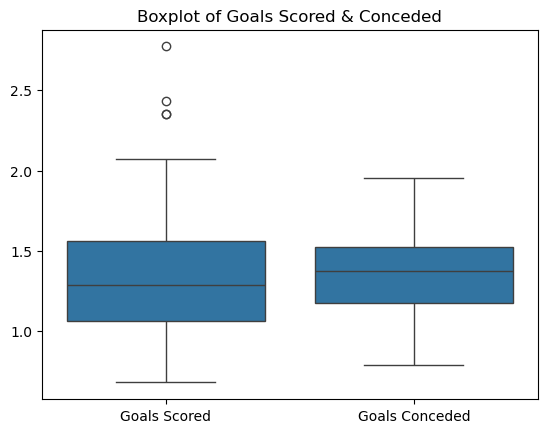


Outliers:


,squad,goals_per90,gk_goals_against_per90,gd_per90,country
0,Bayern Munich,2.7725,1.110294,1.6625,GER
1,Manchester City,2.4350,0.828947,1.6075,ENG
2,PSG,2.3550,0.906433,1.4475,FRA
3,Dortmund,2.3525,1.345588,1.0075,GER



Overview:


,goals_per90,gk_goals_against_per90,gd_per90
count,110.000000,110.000000,110.000000
mean,1.351288,1.363063,-0.011682
std,0.377594,0.255239,0.546968
min,0.680000,0.789474,-0.900000
25%,1.060625,1.174342,-0.390000
50%,1.285000,1.375000,-0.162500
75%,1.563125,1.524906,0.376042
max,2.772500,1.955882,1.662500



Interesting to note that while the mean is about the same, the spread of goals conceded is smaller than that of  goals scored. Does this mean scoring is what separates the better sides from the worse ones?


In [16]:
atk_vs_def_df = pd.merge(
    (
        teams_agg_df[["squad", "goals_per90", "gk_goals_against_per90","gd_per90"]]
        .groupby("squad")
        .mean()
        .reset_index()
    ), teams_agg_df[["squad", "country"]].copy(),
    how="left",
    on="squad",
).drop_duplicates().reset_index(drop=True)

# Boxplot (melt to reshape dataframe and plot both variables on the same graph)
sns.boxplot(x="variable", y="value", data=pd.melt(
    atk_vs_def_df[["goals_per90", "gk_goals_against_per90"]].rename(columns={
        "goals_per90": "Goals Scored", "gk_goals_against_per90": "Goals Conceded",
    })
))

plt.xlabel('')
plt.ylabel('')
plt.title('Boxplot of Goals Scored & Conceded')
plt.show()
        
get_outliers(atk_vs_def_df, 'goals_per90')
print(
    "\nInteresting to note that while the mean is about the same, the spread of goals conceded is smaller than that of ",
    "goals scored. Does this mean scoring is what separates the better sides from the worse ones?"
)

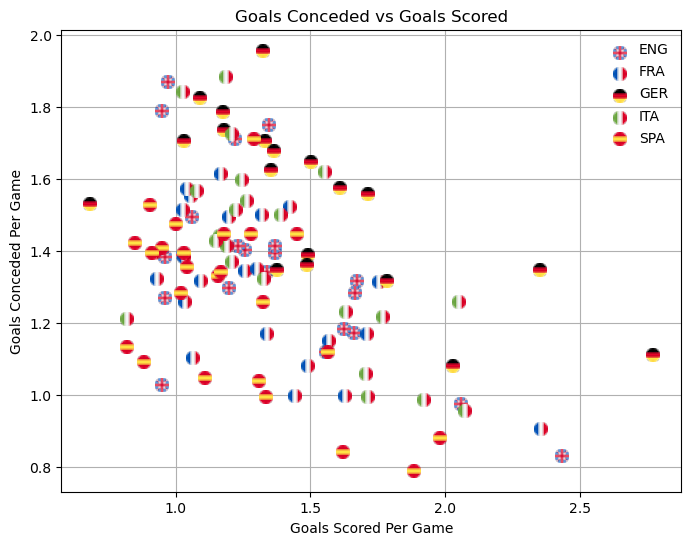

Highest- to lowest-scoring leagues:


,country,goals_per90,gk_goals_against_per90,gd_per90
1,GER,1.507500,1.540506,-0.033377
2,ITA,1.404962,1.393740,0.011250
3,ENG,1.358220,1.355263,0.002803
4,FRA,1.310833,1.305139,0.005870
5,SPA,1.210833,1.257127,-0.045625


Note: Slight differences in goals scored and conceded is due to data for newly promoted teams being pulled from the previous year.


In [17]:
def plot_atk_def_graph():
    plt.xlabel('Goals Scored Per Game')
    plt.ylabel('Goals Conceded Per Game')
    plt.title('Goals Conceded vs Goals Scored')
    plt.grid(True)
    plt.show()

# Dictionary to map categories to images
country_icons = {
    country: get_country_icon(country) for country in list(atk_vs_def_df["country"].sort_values().unique())
}

plt.figure(figsize=(8, 6))

for category, group in atk_vs_def_df.groupby('country'):
    plt.scatter(
        x=group['goals_per90'],
        y=group['gk_goals_against_per90'],
        label=category,
        s=0
    )

#     Set custom markers for country
    for x, y in zip(group['goals_per90'], group['gk_goals_against_per90']):
        imagebox = OffsetImage(country_icons[category])
        plt.gca().add_artist(AnnotationBbox(imagebox, (x, y), frameon=False, pad=0))

plt.legend(framealpha=0, labelspacing=0.6)

# Add icons to each label in legend
for y, image in zip(np.arange(1.95, 1.6, -0.06), country_icons.values()):
    imagebox = OffsetImage(image)
    plt.gca().add_artist(AnnotationBbox(imagebox, (2.65, y), frameon=False, pad=0))

plot_atk_def_graph()

# Rank by country
atk_vs_def_country_df = (
    atk_vs_def_df.drop(columns=['squad']).groupby(by="country")
    .mean()
    .sort_values(by='goals_per90', ascending=False)
    .reset_index()
)
atk_vs_def_country_df.index += 1
print("Highest- to lowest-scoring leagues:")
display(atk_vs_def_country_df)
print(
    "Note: Slight differences in goals scored and conceded is due to data for",
    "newly promoted teams being pulled from the previous year."
)

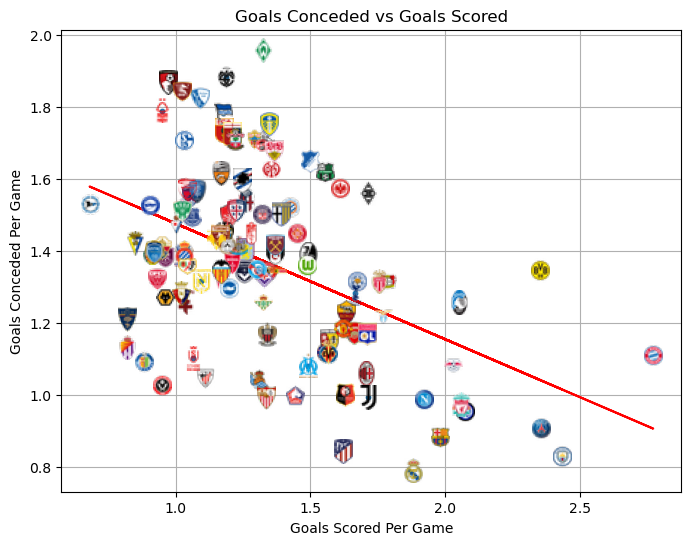

No strong correlation between goals_per90 and gk_goals_against_per90 (corr = -0.40)


In [18]:
plt.figure(figsize=(8, 6))

plt.scatter(
    x=atk_vs_def_df['goals_per90'],
    y=atk_vs_def_df['gk_goals_against_per90'],
    label=category,
    s=10
)

plot_regression_line(atk_vs_def_df, 'goals_per90', 'gk_goals_against_per90')

set_club_markers(atk_vs_def_df, 'goals_per90', 'gk_goals_against_per90')
plot_atk_def_graph()

_ = get_indiv_correlation(teams_agg_df, 'goals_per90', 'gk_goals_against_per90')

Most goals scored


,squad,goals_per90,gk_goals_against_per90,gd_per90,country
1,Bayern Munich,2.7725,1.110294,1.6625,GER
2,Manchester City,2.4350,0.828947,1.6075,ENG
3,PSG,2.3550,0.906433,1.4475,FRA
4,Dortmund,2.3525,1.345588,1.0075,GER
5,Inter,2.0725,0.953947,1.1175,ITA


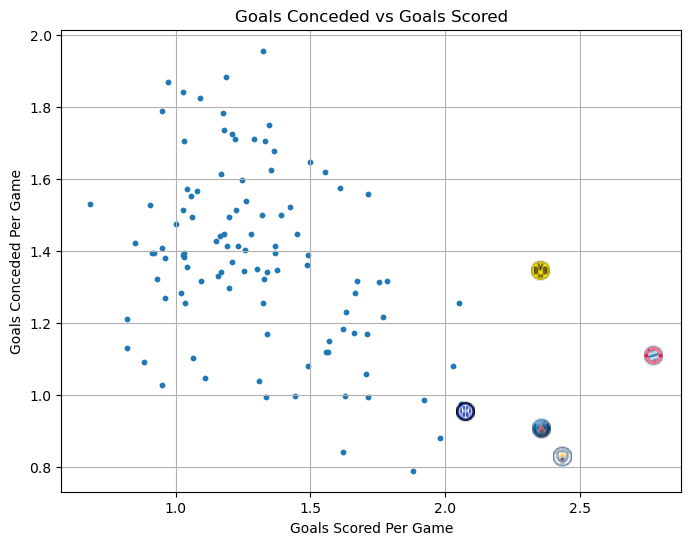

In [19]:
# Most goals scored
print("Most goals scored")
top_5_atk_df = atk_vs_def_df.sort_values(by="goals_per90", ascending=False).head().reset_index(drop=True)
top_5_atk_df.index += 1
display(top_5_atk_df)

plt.figure(figsize=(8, 6))

plt.scatter(
    x=atk_vs_def_df['goals_per90'],
    y=atk_vs_def_df['gk_goals_against_per90'],
    label=category,
    s=10
)

#     Set custom markers for top 5 clubs
set_club_markers(top_5_atk_df, 'goals_per90', 'gk_goals_against_per90')
plot_atk_def_graph()

Fewest goals conceded


,squad,goals_per90,gk_goals_against_per90,gd_per90,country
1,Real Madrid,1.8825,0.789474,1.0900,SPA
2,Manchester City,2.4350,0.828947,1.6075,ENG
3,Atl. Madrid,1.6200,0.842105,0.7775,SPA
4,Barcelona,1.9825,0.881579,1.1000,SPA
5,PSG,2.3550,0.906433,1.4475,FRA


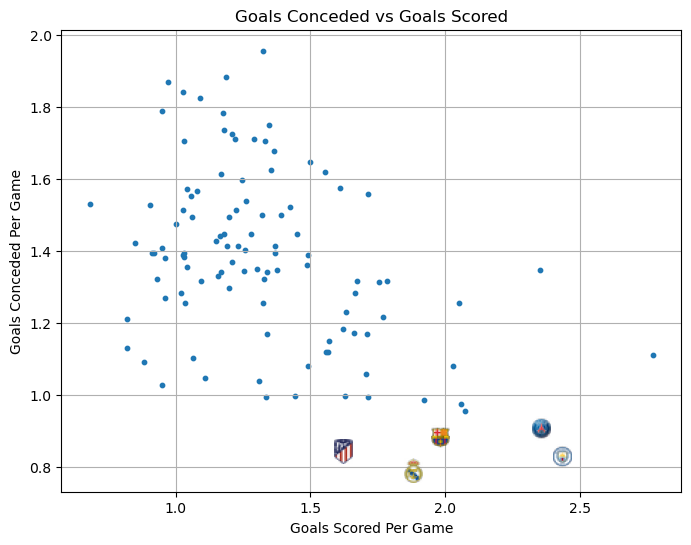

In [20]:
# Fewest goals conceded
print("Fewest goals conceded")
top_5_def_df = atk_vs_def_df.sort_values(by="gk_goals_against_per90").head().reset_index(drop=True)
top_5_def_df.index += 1
display(top_5_def_df)

plt.figure(figsize=(8, 6))

plt.scatter(
    x=atk_vs_def_df['goals_per90'],
    y=atk_vs_def_df['gk_goals_against_per90'],
    label=category,
    s=10
)

#     Set custom markers for top 5 clubs
set_club_markers(top_5_def_df, 'goals_per90', 'gk_goals_against_per90')
plot_atk_def_graph()

Best goal difference


,squad,goals_per90,gk_goals_against_per90,gd_per90,country
1,Bayern Munich,2.7725,1.110294,1.6625,GER
2,Manchester City,2.4350,0.828947,1.6075,ENG
3,PSG,2.3550,0.906433,1.4475,FRA
4,Inter,2.0725,0.953947,1.1175,ITA
5,Barcelona,1.9825,0.881579,1.1000,SPA


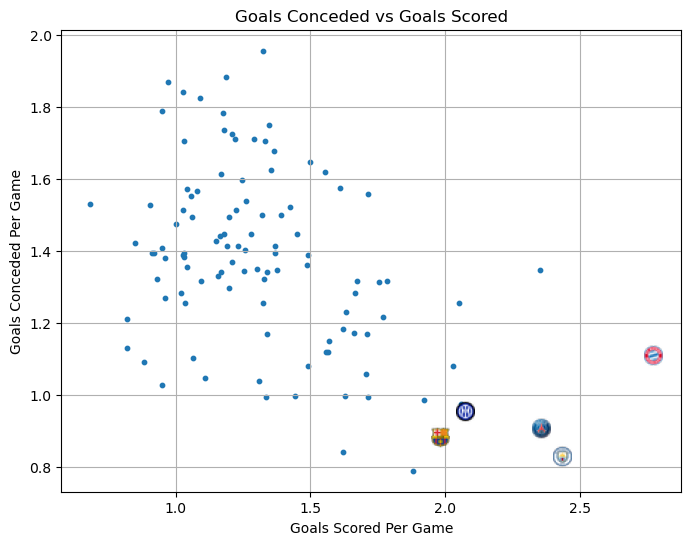

In [21]:
# Best goal difference
print("Best goal difference")
top_5_gd_df = atk_vs_def_df.sort_values(by="gd_per90", ascending=False).head().reset_index(drop=True)
top_5_gd_df.index += 1
display(top_5_gd_df)

plt.figure(figsize=(8, 6))

plt.scatter(
    x=atk_vs_def_df['goals_per90'],
    y=atk_vs_def_df['gk_goals_against_per90'],
    label=category,
    s=10
)

#     Set custom markers for top 5 clubs
set_club_markers(top_5_gd_df, 'goals_per90', 'gk_goals_against_per90')

plot_atk_def_graph()

/tmp/ipykernel_512225/3544489347.py:8: FutureWarning: The provided callable <function mean at 0x7f09101863b0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = teams_agg_df[[*year_cols, col]].groupby(year_cols).agg(agg_func).reset_index()


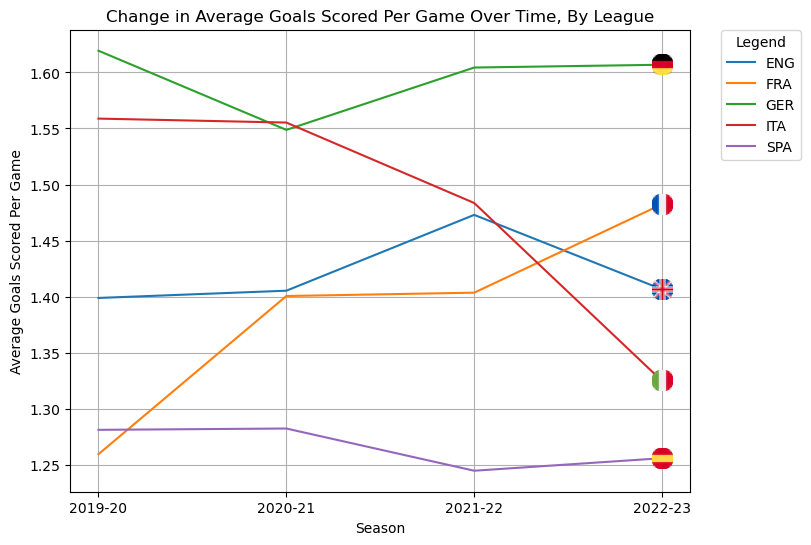

In [22]:
plot_country_line_graph("goals_per90")
    
plt.title("Change in Average Goals Scored Per Game Over Time, By League")
plt.xlabel("Season")
plt.ylabel("Average Goals Scored Per Game")
plt.show()

/tmp/ipykernel_512225/3544489347.py:8: FutureWarning: The provided callable <function mean at 0x7f09101863b0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = teams_agg_df[[*year_cols, col]].groupby(year_cols).agg(agg_func).reset_index()


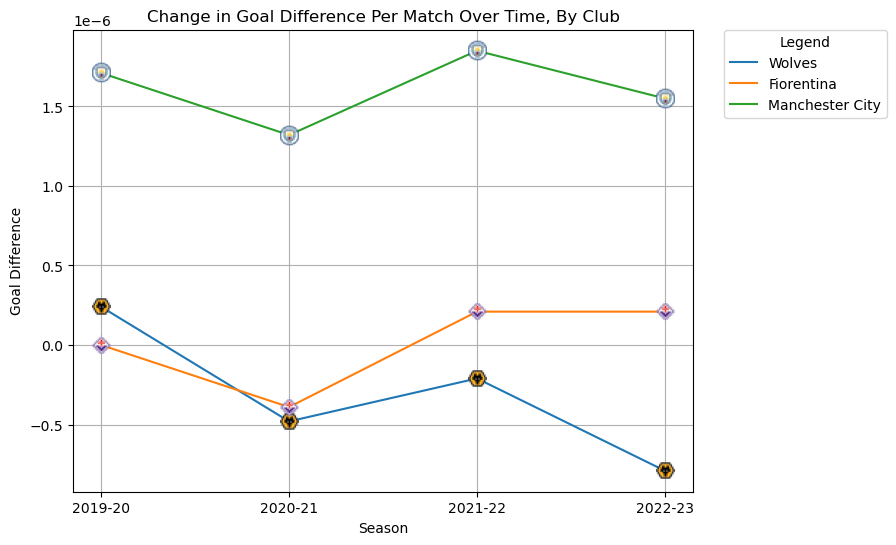

In [23]:
plot_club_line_graph("gd_per90", transform_col_func=lambda x: x/pow(10,6))
    
plt.title("Change in Goal Difference Per Match Over Time, By Club")
plt.xlabel("Season")
plt.ylabel("Goal Difference")
plt.show()

#### Can money buy wins?
<i>Note: the following data has been averaged over the past 5 years (2018-23)</i>

In [24]:
# Correlation to PPG: strong positive correlation between squad value and points per game
# squad_value_avg                          0.768828

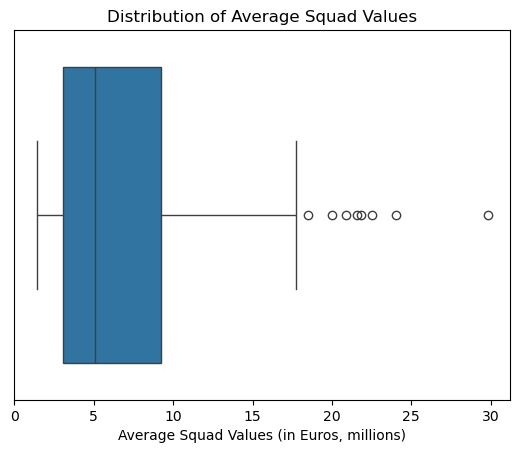


Outliers:


,squad,squad_value_avg,points_per90,country
0,Manchester City,29.8225,2.296053,ENG
1,Real Madrid,24.0075,2.203947,SPA
2,PSG,22.5125,2.294103,FRA
3,Bayern Munich,21.8600,2.264706,GER
4,Chelsea,21.5825,1.651316,ENG
5,Barcelona,20.9075,2.118421,SPA
6,Liverpool,20.0050,2.151316,ENG
7,Tottenham,18.4950,1.657895,ENG



Overview:


,squad_value_avg,points_per90
count,110.000000,110.000000
mean,7.307485,1.401658
std,5.952208,0.348071
min,1.420000,0.947368
25%,3.067500,1.151961
50%,5.087917,1.289474
75%,9.238125,1.651316
max,29.822500,2.296053



Significant outliers. The average squad value of the 99th percentile is a whopping 26.92 standard deviations larger than that of the median, indicating that there is a group of extremely wealthy clubs even amongst the top two tiers.


In [25]:
money_df = pd.merge(
    (
        teams_agg_df[["squad", "squad_value_avg", "points_per90"]]
        .groupby("squad")
        .mean()
        .reset_index()
    ), teams_agg_df[["squad", "country"]].copy(),
        how="left",
        on="squad",
).drop_duplicates().reset_index(drop=True)
money_df["squad_value_avg"] = money_df["squad_value_avg"] / pow(10, 6)

# Boxplot (melt to reshape dataframe and plot both variables on the same graph)
sns.boxplot(data=money_df["squad_value_avg"], orient="h")

plt.xlabel('Average Squad Values (in Euros, millions)')
plt.ylabel('')
plt.yticks([])
plt.title('Distribution of Average Squad Values')
plt.show()

money_outliers_df = get_outliers(money_df, "squad_value_avg")

print(
    "\nSignificant outliers. The average squad value of the 99th percentile",
    f"is a whopping {get_upper_deviation(money_df, 'squad_value_avg')} standard deviations",
    "larger than that of the median, indicating that there is a group of extremely wealthy",
    "clubs even amongst the top two tiers."
)

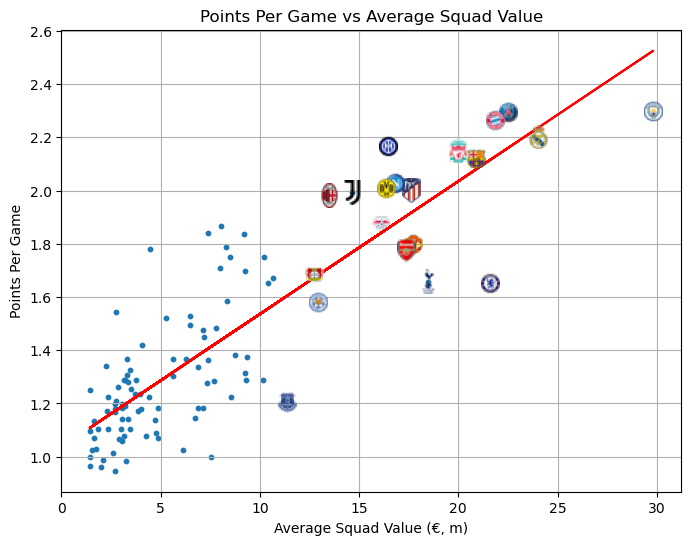

Strong correlation between squad_value_avg and points_per90 (corr = 0.77)


In [26]:
def plot_money_graph():
    plt.xlabel('Average Squad Value (€, m)')
    plt.ylabel('Points Per Game')
    plt.title('Points Per Game vs Average Squad Value')
    plt.grid(True)
    plt.show()

plt.figure(figsize=(8, 6))

plt.scatter(
    x=money_df['squad_value_avg'],
    y=money_df['points_per90'],
    label=money_df["squad"],
    s=10
)

plot_regression_line(money_df, 'squad_value_avg', 'points_per90')

#     Set custom markers for top 20 clubs with highest average squad value
money_top_20_df = money_df.sort_values(by="squad_value_avg", ascending=False).reset_index(drop=True).head(20)
set_club_markers(money_top_20_df, 'squad_value_avg', 'points_per90')
plot_money_graph()

_ = get_indiv_correlation(teams_agg_df, 'squad_value_avg', 'points_per90')

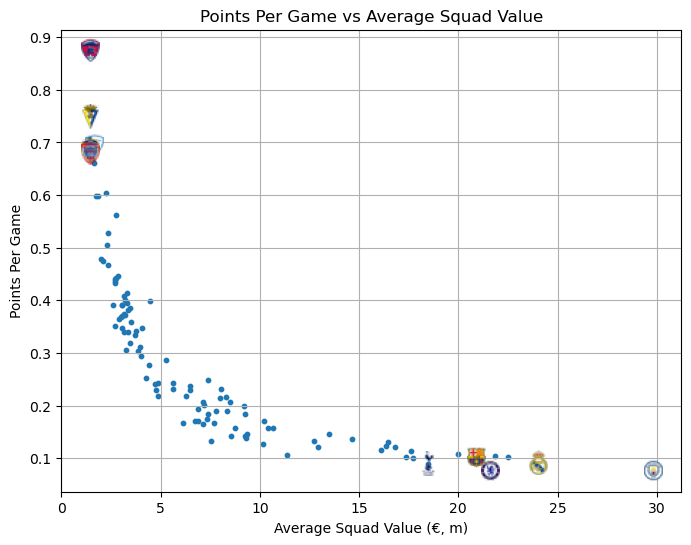


Top 5 "overperforming" teams:
(Teams that earn relatively high amount of points compared to their squad values)


,squad,squad_value_avg,points_per90,country,ppg_value_ratio
1,Clermont,1.430000,1.250000,FRA,0.874126
2,Cadiz CF,1.463333,1.096491,SPA,0.749311
3,Bochum,1.630000,1.132353,GER,0.694695
4,Troyes,1.460000,1.000000,FRA,0.684932
5,Nimes,1.420000,0.964286,FRA,0.679074



Top 5 "underperforming" teams:
(Teams that earn relatively low amount of points compared to their squad values. However, do note that teams can only take home so many points but can spend without a hard limit; some clubs with high PPG here are very successful)


,squad,squad_value_avg,points_per90,country,ppg_value_ratio
1,Chelsea,21.5825,1.651316,ENG,0.076512
2,Manchester City,29.8225,2.296053,ENG,0.076991
3,Tottenham,18.4950,1.657895,ENG,0.089640
4,Real Madrid,24.0075,2.203947,SPA,0.091802
5,Barcelona,20.9075,2.118421,SPA,0.101323


In [27]:
# Points per game to average squad value ratio
money_df["ppg_value_ratio"] = money_df["points_per90"] / money_df["squad_value_avg"]
undervalued_df = money_df.sort_values(by="ppg_value_ratio", ascending=False).reset_index(drop=True).head()
overvalued_df = money_df.sort_values(by="ppg_value_ratio").reset_index(drop=True).head()
undervalued_df.index += 1
overvalued_df.index += 1

plt.figure(figsize=(8, 6))

plt.scatter(
    x=money_df['squad_value_avg'],
    y=money_df['ppg_value_ratio'],
    label=money_df["squad"],
    s=10
)

#     Set custom markers for top 20 clubs with highest average squad value
set_club_markers(pd.concat([undervalued_df, overvalued_df]), 'squad_value_avg', 'ppg_value_ratio')
plot_money_graph()

print("\nTop 5 \"overperforming\" teams:")
print("(Teams that earn relatively high amount of points compared to their squad values)")
display(undervalued_df)

print("\nTop 5 \"underperforming\" teams:")
print(
    "(Teams that earn relatively low amount of points compared to their squad values. However, do note that teams",
    "can only take home so many points but can spend without a hard limit; some clubs with high PPG here are",
    "very successful)"
)
display(overvalued_df)

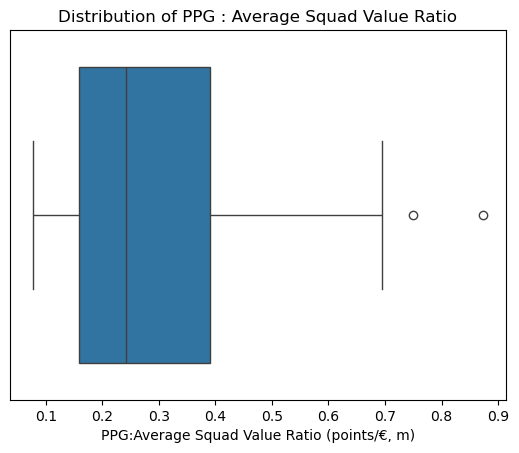


Outliers:


,squad,squad_value_avg,points_per90,country,ppg_value_ratio
0,Clermont,1.430000,1.250000,FRA,0.874126
1,Cadiz CF,1.463333,1.096491,SPA,0.749311



Overview:


,squad_value_avg,points_per90,ppg_value_ratio
count,110.000000,110.000000,110.000000
mean,7.307485,1.401658,0.294543
std,5.952208,0.348071,0.172030
min,1.420000,0.947368,0.076512
25%,3.067500,1.151961,0.158011
50%,5.087917,1.289474,0.242643
75%,9.238125,1.651316,0.390985
max,29.822500,2.296053,0.874126


In [28]:
# Boxplot (melt to reshape dataframe and plot both variables on the same graph)
sns.boxplot(data=money_df["ppg_value_ratio"], orient="h")

plt.xlabel('PPG:Average Squad Value Ratio (points/€, m)')
plt.ylabel('')
plt.yticks([])
plt.title('Distribution of PPG : Average Squad Value Ratio')
plt.show()

money_outliers_df = get_outliers(money_df, "ppg_value_ratio")

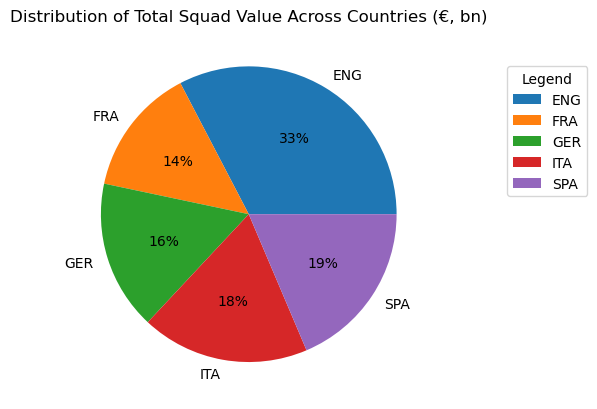

In [29]:
money_sum_by_country_df = teams_agg_df[["squad_value", "country"]].groupby("country").sum()
money_sum_by_country_df["squad_value"] = money_sum_by_country_df["squad_value"] / pow(10, 9)
money_sum_by_country_df.reset_index(inplace=True)

plt.pie(
    money_sum_by_country_df["squad_value"],
    labels=money_sum_by_country_df['country'].unique(),
    autopct='%.0f%%',
)
plt.title("Distribution of Total Squad Value Across Countries (€, bn)")
plt.legend(
    title="Legend",
    labels=money_sum_by_country_df['country'].unique(),
    bbox_to_anchor=(1.2, 0.9),
    loc='upper left',
    borderaxespad=0
)
plt.show()

/tmp/ipykernel_512225/3544489347.py:8: FutureWarning: The provided callable <function mean at 0x7f09101863b0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = teams_agg_df[[*year_cols, col]].groupby(year_cols).agg(agg_func).reset_index()


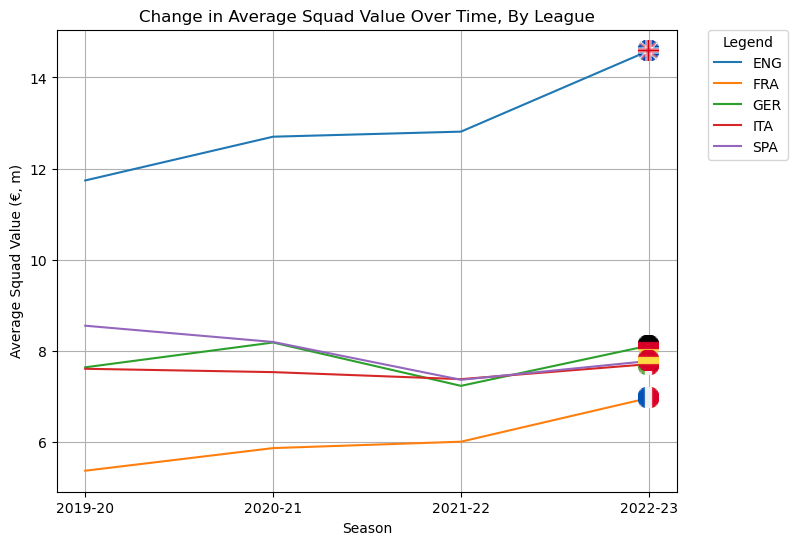

In [30]:
plot_country_line_graph("squad_value_avg", transform_col_func=lambda x: x/pow(10,6))
    
plt.title("Change in Average Squad Value Over Time, By League")
plt.xlabel("Season")
plt.ylabel("Average Squad Value (€, m)")
plt.show()

/tmp/ipykernel_512225/3544489347.py:8: FutureWarning: The provided callable <function mean at 0x7f09101863b0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = teams_agg_df[[*year_cols, col]].groupby(year_cols).agg(agg_func).reset_index()


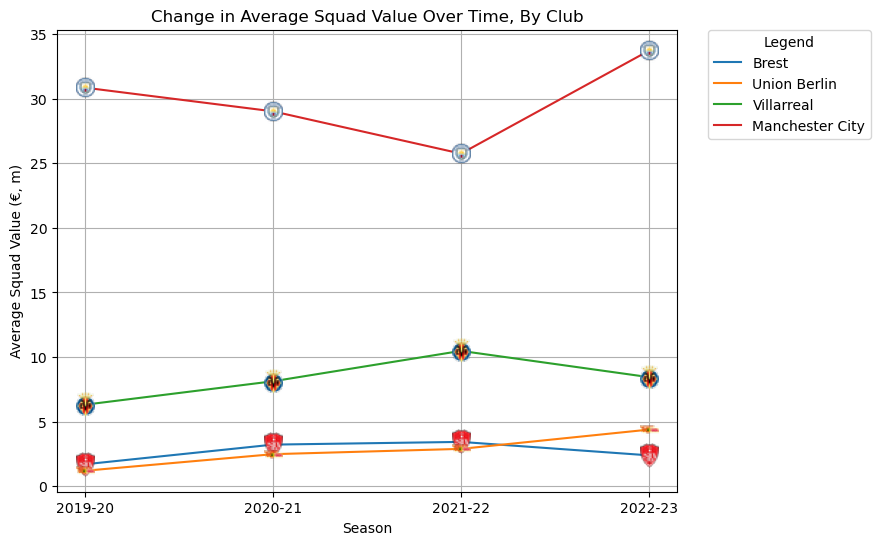

In [31]:
# Shows club at each quartile (based on last season's values)
plot_club_line_graph("squad_value_avg", transform_col_func=lambda x: x/pow(10,6))
    
plt.title("Change in Average Squad Value Over Time, By Club")
plt.xlabel("Season")
plt.ylabel("Average Squad Value (€, m)")
plt.show()

#### Possession vs Counter-Attack

<u>Strong positive correlaton between possession and PPG: more possession-heavy, dominant attacking sides seem to win more points</u>
<ol>
    <li>Correlation between possession & PPG: 0.748007</li>
    <li>
        Correlation between touches_live_ball_per90 & PPG: 0.757463
        <ul>
            <li>
                High possession naturally means more touches on the ball:
                <ul><li>Correlation between touches_live_ball_per90 & possession: 0.950651</li></ul>
            </li>
        </ul>
    </li>
    <li>
        Correlation between touches_att_3rd_per90 & PPG: 0.768357
        <ul>
            <li>
                More touches on the ball -> touches in the attacking third (strong positive correlation):
                <ul><li>Correlation between touches_att_3rd_per90 & possession: 0.853383</li></ul>
            </li>
            <li>
                More touches in the attacking third -> (strong positive correlation):
                <ul>
                    <li>Correlation between touches_att_3rd_per90 & sca_per90: 0.831509</li>
                    <li>Correlation between touches_att_3rd_per90 & sca_passes_live_per90: 0.863127</li>
                </ul>
            </li>
            <li>
                More shot-creating actions -> more goals (strong positive correlation):
                <ul>
                    <li>Correlation between sca_per90 & goals_per90: 0.788389</li>
                    <li>Correlation between sca_per90 & xg_per90: 0.861268</li>
                </ul>
            </li>
        </ul>
    </li>
    <li>
        Correlation between passes_total_distance_per90 & PPG: 0.753216
        <ul>
            <li>
                High possession naturally means more passes and thus more passing distance:
                <ul><li>Correlation between passes_total_distance_per90 & possession: 0.942511</li></ul>
            </li>
        </ul>
    </li>
</ol>
<i>To see how the correlation is derived, uncomment the relavant line of code in the next cell</i>

In [32]:
# Comments below are same as explanation above; uncomment .corr() code lines to view all correlations to that variable

# Strong positive correlaton to PPG: more possession-heavy, dominant attacking sides seem to win more points
# possession & PPG                         0.748007
numeric_df.corr()["possession"].sort_values()
# touches_live_ball_per90 & PPG            0.757463
    # High possession naturally means more touches on the ball
        # touches_live_ball_per90 & possession     0.950651
# touches_att_3rd_per90 & PPG              0.768357
    # More touches on the ball -> touches in the attacking third (strong positive correlation)
        # touches_att_3rd_per90 & possession       0.853383
    # More touches in the attacking third -> more shot-creating actions -> more goals (strong positive correlation)
        # teams_agg_df.corr()["touches_att_3rd_per90"].sort_values()
            # sca_per90 & touches_att_3rd_per90                 0.831509
            # sca_passes_live_per90 & touches_att_3rd_per90     0.863127
        # teams_agg_df.corr()["sca_per90"].sort_values()
            # goals_per90 & sca_per90                  0.788389
            # xg_per90 & sca_per90                     0.861268
# passes_total_distance_per90 & PPG         0.753216
    # High possession naturally means more passes and thus more passing distance
        # passes_total_distance_per90 & possession  0.942511

gk_pct_passes_launched                  -0.764267
clearances_per90                        -0.747496
gk_goal_kick_length_avg                 -0.639852
aerials_lost_per90                      -0.609742
gk_shots_on_target_against_per90        -0.546793
gk_psxg                                 -0.539470
gk_goals_against_per90                  -0.536605
goals_against_per90                     -0.536497
goals_against_away_per90                -0.502541
blocked_shots_per90                     -0.497051
aerials_won_per90                       -0.478762
tackles_def_3rd_per90                   -0.458523
goals_against_home_per90                -0.379040
blocks_per90                            -0.361970
interceptions_per90                     -0.329118
take_ons_tackled_pct                    -0.321513
passes_dead_per90                       -0.321182
average_shot_distance                   -0.320237
fouls_per90                             -0.313081
tackles_interceptions_per90             -0.291598


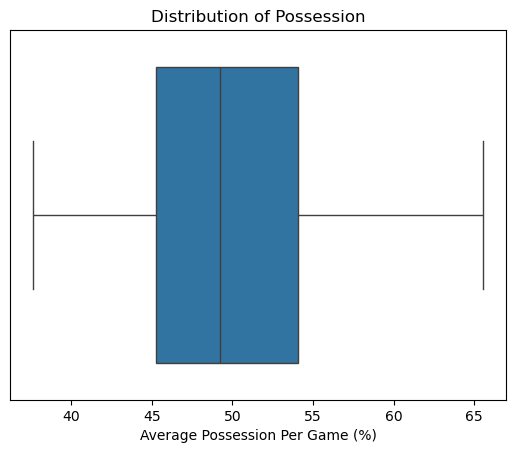


Overview:


,possession,points_per90
count,110.000000,110.000000
mean,49.795606,1.401658
std,5.813727,0.348071
min,37.600000,0.947368
25%,45.287500,1.151961
50%,49.200000,1.289474
75%,54.043750,1.651316
max,65.575000,2.296053



No outliers. However, the average squad value of the 99th percentile is a massive 65.34 standard deviations larger than that of the median, while the 1st percentile is 65.34 SDs below the median. This could be a reflection of vastly different playing styles by a few clubs.


In [33]:
possession_df = pd.merge(
    (
        teams_agg_df[["squad", "possession", "points_per90"]]
        .groupby("squad")
        .mean()
        .reset_index()
    ), teams_agg_df[["squad", "country"]].copy(),
        how="left",
        on="squad",
).drop_duplicates().reset_index(drop=True)

# Boxplot (melt to reshape dataframe and plot both variables on the same graph)
sns.boxplot(data=possession_df["possession"], orient="h")

plt.xlabel('Average Possession Per Game (%)')
plt.ylabel('')
plt.yticks([])
plt.title('Distribution of Possession')
plt.show()

possession_outliers_df = get_outliers(possession_df, "possession")

print(
    "\nNo outliers. However, the average squad value of the 99th percentile",
    f"is a massive {get_upper_deviation(possession_df, 'possession')} standard deviations",
    "larger than that of the median, while the 1st percentile is",
    f"{get_upper_deviation(possession_df, 'possession')} SDs below the median.",
    "This could be a reflection of vastly different playing styles by a few clubs."
)

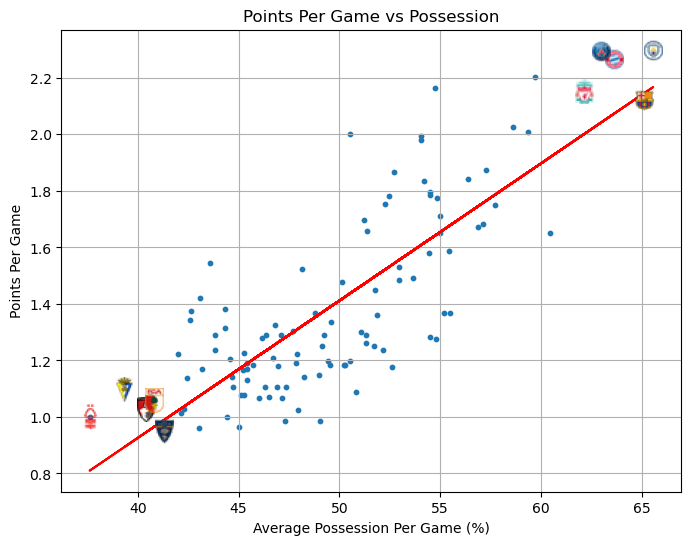


Top 5 posession-based teams:


,squad,possession,points_per90,country
1,Manchester City,65.575,2.296053,ENG
2,Barcelona,65.100,2.118421,SPA
3,Bayern Munich,63.625,2.264706,GER
4,PSG,63.000,2.294103,FRA
5,Liverpool,62.125,2.151316,ENG



Top 5 counter-attacking teams:


,squad,possession,points_per90,country
1,Nottingham,37.600000,1.000000,ENG
2,Cadiz CF,39.333333,1.096491,SPA
3,Bournemouth,40.400000,1.026316,ENG
4,Augsburg,40.800000,1.058824,GER
5,Lecce,41.300000,0.947368,ITA


Strong correlation between possession and points_per90 (corr = 0.81)


In [34]:
def plot_possession_graph():
    plt.xlabel('Average Possession Per Game (%)')
    plt.ylabel('Points Per Game')
    plt.title('Points Per Game vs Possession')
    plt.grid(True)
    plt.show()

plt.figure(figsize=(8, 6))

plt.scatter(
    x=possession_df['possession'],
    y=possession_df['points_per90'],
    label=possession_df["squad"],
    s=10
)

plot_regression_line(possession_df, 'possession', 'points_per90')

# Most and least posession-based teams
possession_top_5_df = possession_df.sort_values(by="possession", ascending=False).reset_index(drop=True).head()
park_bus_top_5_df = possession_df.sort_values(by="possession").reset_index(drop=True).head()
possession_top_5_df.index += 1
park_bus_top_5_df.index += 1

#     Set custom markers for extreme-cases
set_club_markers(pd.concat([possession_top_5_df, park_bus_top_5_df]), 'possession', 'points_per90')
plot_possession_graph()

print("\nTop 5 posession-based teams:")
display(possession_top_5_df)

print("\nTop 5 counter-attacking teams:")
display(park_bus_top_5_df)

_ = get_indiv_correlation(possession_df, 'possession', 'points_per90')

#### Other Correlations and Resulting Observations

1. Categorize Your Variables
Group your variables into categories as per your dictionary. For example:

- Possession: touches, touches_def_3rd, carries, passes_pct, etc.
- Defense: tackles, tackles_won, blocked_shots, interceptions, etc.
- Offense: goals_for, shots_on_target, assists, etc.
- Goalkeeping: gk_save_pct, gk_clean_sheets_pct, gk_goals_against, etc.

2. Compute Intra-Category Correlations
Before looking at cross-category correlations, you should identify and potentially exclude intra-category correlations that are very high. This step helps in focusing only on the most representative features within each category or possibly reducing the features based on factor analysis or principal component analysis (PCA).

3. Compute Inter-Category Correlations
After reducing the dimensionality within each category, you can compute the correlations between features from different categories. This will help you identify how features across different aspects of the game relate to each other with respect to influencing the points scored per 90 minutes.

4. Filter and Visualize
Set a threshold for the correlation values to filter out low correlations. This will simplify your analysis by focusing only on significant relationships. Visualization tools such as heatmaps or network graphs can be particularly helpful in understanding these relationships visually.

5. Regression Analysis
To further explore which variables are the best predictors for points_per90, you could run a multiple regression analysis. Include selected variables from different categories as independent variables and points_per90 as the dependent variable. This will not only provide insights into which features are strong predictors but also how they interact with each other.

6. Regularization Techniques
If there are still too many variables and multicollinearity is a concern, consider using regularization techniques like Ridge or Lasso regression. These methods can help in selecting a more parsimonious model, reducing the number of predictors while handling multicollinearity.

In [35]:
def plot_jointplot(df, col1, col2, label, options={}):
    '''options is a dictionary that can contain the following attributes:
    figsize: A tuple
    cmap: defaults to coolwarm
    fig_specs: a dictionary with the following: title, xlabel, ylabel, label_fontsize
    '''
    
    if label not in df.columns:
        print(f"Column for label: {label} was not found in dataframe")
        return
    
    fig_specs = options.get('fig_specs', {})
    
    g = sns.jointplot(x=col1, y=col2, data=df, kind='scatter')
    
    params = options.get('params', {})
    params['cmap'] = params.get('cmap', 'coolwarm')
    scatter = g.ax_joint.scatter(df[col1], df[col2], c=df[label], **params)

    # color bar
    cbar = plt.colorbar(scatter, ax=g.ax_joint)
    cbar.set_label(label)
    
    plt.subplots_adjust(top=0.9)
    g.figure.suptitle(fig_specs.get('title', f'Reg Plot of {label} for {col1} and {col2}'), fontsize=fig_specs.get('title_fontsize', 16))
    g.set_axis_labels(fig_specs.get('xlabel', col1), fig_specs.get('ylabel', col2), fontsize=fig_specs.get('label_fontsize', 12))

    plt.show()

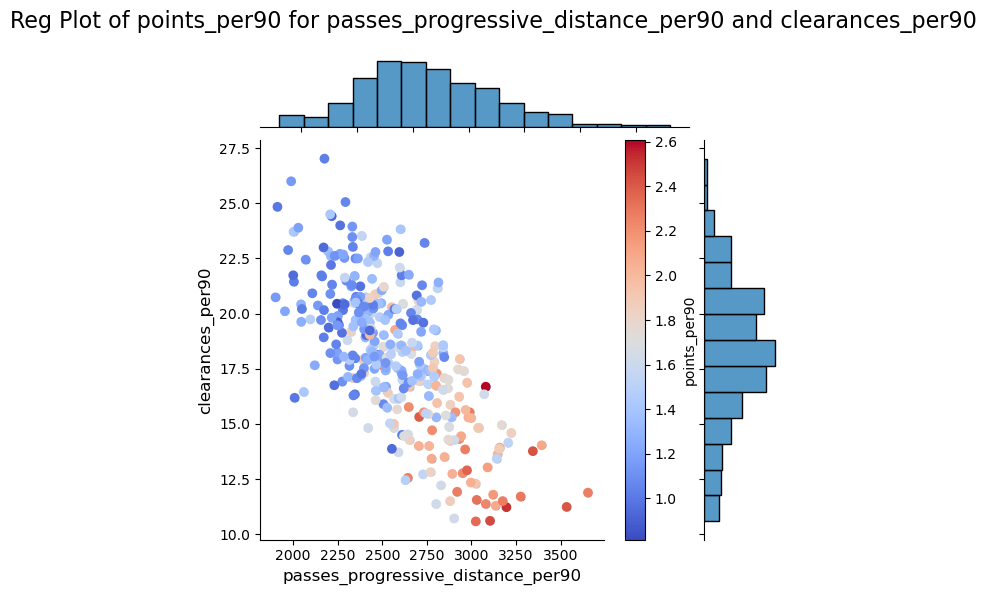

In [36]:
plot_jointplot(teams_agg_df, 'passes_progressive_distance_per90', 'clearances_per90', 'points_per90')

- Inverse correlation between Clearances and Progressive passes 
- Positive correlation between Progressive passes and Points
- Inverse correlation between Clearances and Points

In [87]:
from constants import AGG_COL_TO_CAT_DICT_FILE

with open(AGG_COL_TO_CAT_DICT_FILE, 'rb') as file:
    AGG_COL_TO_CAT_DICT = pickle.load(file)

def check_columns(col1, col2, keywords=['pass']):
    min_threshold = 0.65
    max_threshold = 0.75
    if not min_threshold <= abs(corr_matrix.at['points_per90', col1]) <= max:
        return False

    if col1 == col2 or AGG_COL_TO_CAT_DICT[col1] == AGG_COL_TO_CAT_DICT[col2]:
        return False
    
    for keyword in keywords:
        if keyword in col1 and keyword in col2:
            return False
    
    return True


corr_cols = []
for col1 in corr_matrix['points_per90'].index:
    # Check if the correlation between 'points_per90' and 'col1' is significant
    if check_columns(col1, 'points_per90'):
        # Now check this 'col1' against all other features
        for col2 in corr_matrix.index:
            if check_columns(col1, col2) and check_columns(col2, 'points_per90'):
                print(f"Correlation found between 'points_per90', '{col1}', and '{col2}")
                corr_cols.append((col1, col2, 'points_per90'))

if len(corr_cols) == 0:
    print("No Correlations found")

Correlation found between 'points_per90', 'passes_pct', and 'gk_goals_against_per90
Correlation found between 'points_per90', 'passes_pct', and 'gk_clean_sheets_pct
Correlation found between 'points_per90', 'passes_pct', and 'gk_psxg
Correlation found between 'points_per90', 'passes_pct', and 'goals_against_per90
Correlation found between 'points_per90', 'passes_pct', and 'goals_against_away_per90
Correlation found between 'points_per90', 'passes_pct', and 'possession
Correlation found between 'points_per90', 'passes_pct', and 'touches_mid_3rd_per90
Correlation found between 'points_per90', 'passes_pct', and 'carries_per90
Correlation found between 'points_per90', 'passes_pct', and 'carries_distance_per90
Correlation found between 'points_per90', 'passes_pct', and 'progressive_carries_per90
Correlation found between 'points_per90', 'passes_pct', and 'carries_progressive_distance_per90
Correlation found between 'points_per90', 'passes_pct', and 'carries_into_final_third_per90
Correlatio

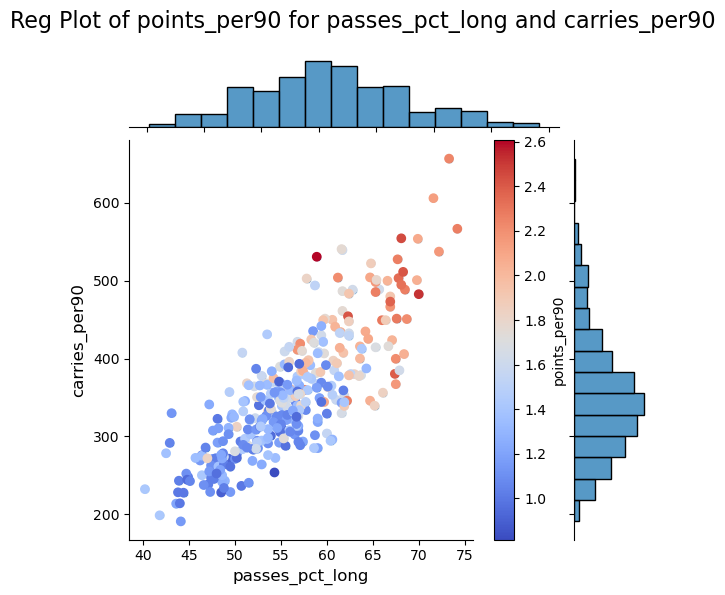

In [98]:
# SELECT A RANDOM COLUMN
import random
if len(corr_cols) > 0:
    idx = random.randint(0, len(corr_cols) - 1)
    # Select the element at the random index
    selected_column = corr_cols[idx]

    plot_jointplot(teams_agg_df, *selected_column)
else:
    print("No correlations found")

Correlation to PPG

In [37]:
# Having to clear more often means opponents are creating more chances more often
# Indicative of back-foot play? Is high-pressing/high-possession the way to go?
# clearances_per90                        -0.642397
# tackles_def_3rd_per90                   -0.457455
# blocked_shots_per90                     -0.405874

# Importance of aerial duels
# aerials_lost_per90                      -0.526721

# More likely to lose if goalkeeper plays long?
# Need more data to check if goalkeeper plays long == don't build from the back == less-possession-based
# gk_pct_passes_launched                  -0.557303

# Easier to score from inside the box
# touches_att_pen_area_per90               0.774190
# passes_into_final_third_per90            0.780436

# Dribbling is important too
# carries_per90                            0.711977
# carries_into_penalty_area_per90          0.704944
# carries_progressive_distance_per90       0.698366

# Importance of set pieces
# corner_kicks_per90                       0.619333

# Creating chances > finishing chances
# shots_on_target_per90                    0.774389
# goals_per_shot_on_target                 0.527539

# High press is not always better
# tackles_att_3rd                          0.444717
# tackles_att_3rd_per90                    0.471157

Cross-category correlation

In [38]:
# Get correlation
teams_corr_df = get_correlation(teams_agg_df, list(teams_agg_df.columns))

# Filter out correlations between similar variables
teams_corr_df = teams_corr_df[
    teams_corr_df.apply(
        lambda row: in_different_category(row['col_1'], row['col_2']),
        axis=1
    )
].reset_index(drop=True)

ValueError: could not convert string to float: 'Aston Villa'

In [ ]:
# Note: the following correlation values are absolute (i.e. |corr|)
# as we are measuring strength of correlationship for now
# KIV: are a few outliers skewing the metrics?

# Strong correlation between passes and carries
# passes_live	carries_distance	0.889320
# passes_into_final_third	carries	0.883365
# passes_pct	carries	0.835825

# Strong correlation between progressive actions and: g/a, possession
# teams_corr_df[
#     (teams_corr_df['col_1'].str.contains("progressive", regex=True)) |
#     (teams_corr_df['col_2'].str.contains("progressive", regex=True))
# ]

# Strong correlation between possession and g/a
# teams_corr_df[
#     (
#         (teams_corr_df['col_1'].str.contains("possession", regex=True)) &
#         (teams_corr_df['col_2'].str.contains("x", regex=True))
#     ) | (
#         (teams_corr_df['col_1'].str.contains("x", regex=True)) &
#         (teams_corr_df['col_2'].str.contains("possession", regex=True))
#     )
# ]

# Looking at defensive metrics
# teams_corr_df[
#     (teams_corr_df['col_1'].isin(TEAM_COLUMNS_DICT_COMBINED["defence"])) |
#     (teams_corr_df['col_2'].isin(TEAM_COLUMNS_DICT_COMBINED["defence"]))
# ]

# High press =/= high possession
# teams_corr_df[
#     (teams_corr_df['col_1'].str.contains("tackles_att_3rd", regex=True)) |
#     (teams_corr_df['col_2'].str.contains("tackles_att_3rd", regex=True))
# ]

# Q: Is technical and physical ability mutually exclusive?
# A: Probably not? More direct/long-ball teams may lose more aerial duels and
# have lower overall pass accuracy (because of long balls)
# passes_pct	aerials_lost	0.756948
# passes_pct_short	aerials_won	0.625621